<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
import Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn import metrics

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve, precision_score, recall_score,confusion_matrix,f1_score,fbeta_score, make_scorer


# Obter os dataframes dos ficheiros

In [2]:
failures_df, signals_df, logs_df = dprep.get_data()

In [3]:
df_list = [failures_df, signals_df, logs_df]

In [4]:
#df_list

# Criação de datasets de components

In [5]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [6]:
comp_df_list = [df_generator, df_hydraulic, df_gen_bear, df_transformer,  df_gearbox]

In [7]:
for i in comp_df_list:
    print(i.shape)

(434145, 45)
(434145, 31)
(434145, 45)
(434145, 36)
(434145, 33)


In [8]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Merge dos DF com o DF de failures

In [9]:
for i in range(len(component_list)):
    comp_df_list[i] = dprep.sig_fail_merge_dfs(sig_df=comp_df_list[i],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [10]:
for i in comp_df_list:
    print(i.shape)

(434147, 46)
(434145, 32)
(434145, 46)
(434145, 37)
(434145, 34)


# Fillna by turbine

In [11]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [12]:
for i in range(len(component_list)):
    comp_df_list[i] = dprep.fill_na_by_turbine(comp_df_list[i], turbine_list)

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on 

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['date'] = df_merged['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:171: SettingWithCopyWarning: 
A value is trying to be

In [13]:
for i in comp_df_list:
    print(i.shape)

(434147, 47)
(434145, 33)
(434145, 47)
(434145, 38)
(434145, 35)


# Criação de Variável alvo

In [14]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].isna().sum().value_counts())

0    47
dtype: int64
0    33
dtype: int64
0    47
dtype: int64
0    38
dtype: int64
0    35
dtype: int64


In [15]:
days_list = [60, 50, 40, 30, 20, 10]

In [16]:
for day in days_list:
    for i in range(len(comp_df_list)):
        comp_df_list[i] = dprep.aplic_var_target(comp_df_list[i], day)

In [17]:
for i in comp_df_list:
    print(i.shape)

(434147, 53)
(434145, 39)
(434145, 53)
(434145, 44)
(434145, 41)


# Feature selection

In [18]:
for i in comp_df_list:
    print(i.keys())

Index(['Timestamp', 'Turbine_ID', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Gen_SlipRing_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'Rtr_RPM_Max',
       'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Std',
       'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg',
       'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg',
       'Amb_Temp_Avg', 'Amb_WindSpeed_Est_Avg', 'Blds_PitchAngle_Min',
       'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg',
       'Nac

In [19]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [20]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [21]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [22]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [23]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [24]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [25]:
for df in range(len(comp_df_list)):
    print(f'A actualizar dataframe {df+1} de {len(comp_df_list)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_df_list[df] = comp_df_list[df].drop(columns=feat_drop_list[df])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [26]:
for i in comp_df_list:
    print(i.shape)

(434147, 36)
(434145, 28)
(434145, 36)
(434145, 33)
(434145, 31)


In [27]:
for i in comp_df_list:
    print(i.keys())

Index(['Timestamp', 'Turbine_ID', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Gen_Bear_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0',
       'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_ReactPwrGen0',
       'Gen_SlipRing_Temp_Avg', 'Gen_Bear2_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg',
       'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Blds_PitchAngle_Avg',
       'Blds_PitchAngle_Std', 'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
       'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg', 'Nac_Direction_Avg',
       'Grd_Busbar_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Component', 'TTF',
       '60_days', '50_days', '40_days', '30_days', '20_days', '10_days'],
      dtype='object')
Index(['Timestamp', 'Turbine_ID', 'Hyd_Oil_Temp_Avg', 'Rtr_RPM_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Rtr_RPM_Std', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_Wi

# Agrupar pela medida de tempo seleccionada.

In [28]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(434147, 36)
(434145, 28)
(434145, 36)
(434145, 33)
(434145, 31)


In [29]:
# Passagem para dias 
for i in range(len(comp_df_list)):
    comp_df_list[i] = dprep.group_por_frequency(comp_df_list[i])

In [30]:
# Passagem para dias 
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(3042, 36)
(3041, 21)
(3041, 23)
(3041, 24)
(3041, 21)


# Adicionar as medidas de alisamento

In [31]:
for i in range(len(comp_df_list)):
    comp_df_list[i] = dprep.add_features(comp_df_list[i])

In [32]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(3042, 90)
(3041, 45)
(3041, 51)
(3041, 54)
(3041, 45)


In [33]:
def prepare_train_df_mig(df, meses=3):
    last_date = df['Date'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    df_train = df[df['Date'] < split]
    # df_test = df[df['Timestamp'] >= split]
    return df_train

def prepare_test_df_mig(df):
    last_date = df['Date'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    # df_train = df[df['Timestamp'] < split]
    df_test = df[df['Date'] >= split]
    return df_test

In [34]:
#comp_df_list[0].columns

# Train and test split

In [35]:
# Preparar a lista de X_train
df_train = [0, 0, 0, 0, 0]
df_test = [0, 0, 0, 0, 0]

#for i in range(len(comp_df_list)):
#    df_train[i] = dprep.prepare_train_df(comp_df_list[i])
#    df_test[i] = dprep.prepare_test_df(comp_df_list[i])

for i in range(len(comp_df_list)):
    df_train[i] = prepare_train_df_mig(comp_df_list[i])
    df_test[i] = prepare_test_df_mig(comp_df_list[i])

In [36]:
for i in range(len(df_train)):
    print(f'x_train {i} com a forma {df_train[i].shape}')
    print(f'x_test {i} com a forma {df_test[i].shape}')

x_train 0 com a forma (2577, 90)
x_test 0 com a forma (465, 90)
x_train 1 com a forma (2576, 45)
x_test 1 com a forma (465, 45)
x_train 2 com a forma (2576, 51)
x_test 2 com a forma (465, 51)
x_train 3 com a forma (2576, 54)
x_test 3 com a forma (465, 54)
x_train 4 com a forma (2576, 45)
x_test 4 com a forma (465, 45)


In [39]:
df_train[3]

,Turbine_ID,Date,Rtr_RPM_Avg,Rtr_RPM_Std,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,...,Amb_WindSpeed_Std_sd,Amb_WindDir_Relative_Avg_sd,Amb_WindDir_Abs_Avg_sd,Blds_PitchAngle_Avg_sd,Blds_PitchAngle_Std_sd,Nac_Direction_Avg_sd,Grd_Prod_VoltPhse1_Avg_sd,Grd_Prod_VoltPhse2_Avg_sd,Grd_Prod_VoltPhse3_Avg_sd,Component_sd
0,T01,2016-01-01,9.651389,0.854167,11.759028,1.302083,5.070833,1.004167,2.999306,228.367361,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,T01,2016-01-02,5.104861,0.529167,10.868056,0.905556,3.823611,0.864583,0.343056,205.900694,...,0.098700,1.878252,15.886332,7.342616,0.481225,45.821993,0.487118,0.229810,1.028742,0.0
2,T01,2016-01-03,7.403472,0.371528,12.512500,1.264583,5.527083,1.136111,0.802083,217.303472,...,0.135782,1.419751,11.233759,5.260387,0.493652,44.775715,0.378441,0.200281,1.042490,0.0
3,T01,2016-01-04,14.404167,0.349306,20.471528,1.943750,9.439583,1.877778,2.142361,267.268056,...,0.451889,1.220053,26.665928,7.094254,0.405716,45.540714,0.427380,0.619429,2.156889,0.0
4,T01,2016-01-05,13.881250,0.434722,19.715278,1.894444,9.043056,1.802083,-0.707639,306.820139,...,0.469855,1.468154,41.503033,6.999738,0.355305,55.760338,0.370950,0.579462,2.050402,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,T11,2017-05-27,6.300694,0.705556,9.547917,1.136806,4.123611,0.878472,1.901389,132.447222,...,0.695216,1.929519,64.743659,5.880264,0.868690,68.482547,0.553783,0.374598,1.678807,0.0
2944,T11,2017-05-28,9.435417,0.752778,11.033333,1.383333,4.737500,0.933333,-2.889583,207.543750,...,0.688115,2.015712,60.960084,5.878832,0.867409,65.132722,0.554470,0.374875,1.714121,0.0
2945,T11,2017-05-29,9.326389,0.656250,10.938889,1.223611,4.443056,0.869444,-2.317361,243.740972,...,0.676275,1.862911,55.456488,5.175148,0.847930,55.675888,0.541394,0.365562,1.722180,0.0
2946,T11,2017-05-30,7.468056,0.739583,9.150694,1.022222,3.933333,0.781250,2.915972,245.335417,...,0.698479,1.985275,59.334088,5.144751,0.818920,60.370479,0.539451,0.344823,1.750095,0.0


In [55]:
df_train[3][df_train[3]['Turbine_ID'].isin(['T07','T11'])]

,Turbine_ID,Date,Rtr_RPM_Avg,Rtr_RPM_Std,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,...,Amb_WindSpeed_Std_sd,Amb_WindDir_Relative_Avg_sd,Amb_WindDir_Abs_Avg_sd,Blds_PitchAngle_Avg_sd,Blds_PitchAngle_Std_sd,Nac_Direction_Avg_sd,Grd_Prod_VoltPhse1_Avg_sd,Grd_Prod_VoltPhse2_Avg_sd,Grd_Prod_VoltPhse3_Avg_sd,Component_sd
1211,T07,2016-01-01,10.016667,0.869444,12.309028,1.147917,4.969444,1.028472,-0.660417,210.426389,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1212,T07,2016-01-02,5.215972,0.590972,10.490972,0.878472,3.912500,0.858333,13.150694,213.786806,...,0.120306,9.765930,2.376173,8.198510,0.193472,19.121346,0.769470,0.375650,1.570857,0.0
1213,T07,2016-01-03,7.459722,0.423611,13.497917,1.200694,5.493056,1.170833,2.737500,209.463194,...,0.156456,7.196379,2.269866,5.894869,0.547410,13.782841,0.586410,0.266624,1.131476,0.0
1214,T07,2016-01-04,14.218056,0.447222,22.902778,1.847222,9.082639,1.962500,-0.142361,251.304861,...,0.488637,6.429065,20.125218,7.313700,0.450689,16.930810,0.603847,0.218147,1.808117,0.0
1215,T07,2016-01-05,14.143056,0.407639,21.346528,2.176389,9.253472,1.793750,-0.362500,297.394444,...,0.486947,5.866635,38.255802,7.116265,0.393459,32.670590,0.582990,0.195248,1.831731,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,T11,2017-05-27,6.300694,0.705556,9.547917,1.136806,4.123611,0.878472,1.901389,132.447222,...,0.695216,1.929519,64.743659,5.880264,0.868690,68.482547,0.553783,0.374598,1.678807,0.0
2944,T11,2017-05-28,9.435417,0.752778,11.033333,1.383333,4.737500,0.933333,-2.889583,207.543750,...,0.688115,2.015712,60.960084,5.878832,0.867409,65.132722,0.554470,0.374875,1.714121,0.0
2945,T11,2017-05-29,9.326389,0.656250,10.938889,1.223611,4.443056,0.869444,-2.317361,243.740972,...,0.676275,1.862911,55.456488,5.175148,0.847930,55.675888,0.541394,0.365562,1.722180,0.0
2946,T11,2017-05-30,7.468056,0.739583,9.150694,1.022222,3.933333,0.781250,2.915972,245.335417,...,0.698479,1.985275,59.334088,5.144751,0.818920,60.370479,0.539451,0.344823,1.750095,0.0


In [51]:
df_train[3][df_train[3]['Turbine_ID']=='T07' or df_train[3]['Turbine_ID']=='T11']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [38]:
df_train_generator   = df_train[0]
df_train_hydraulic   = df_train[1]
df_train_gen_bear    = df_train[2]
df_train_transformer = df_train[3]['Turbine_ID'=='T07']
df_train_gearbox     = df_train[4]

df_test_generator   = df_test[0]
df_test_hydraulic   = df_test[1]
df_test_gen_bear    = df_test[2]
df_test_transformer = df_test[3]
df_test_gearbox     = df_test[4]

Alterações que fiz ao código do Ricardo:

-> adicionei mais variaveis alvo (pois so estava a 60 dias)
-> usei uma versao adaptada da funçao criada para fazer train/test split

In [39]:
#pred_LogReg[['y_score']].hist()
#pred_LogReg[['y_score']][df_test.eq(1).values].hist()

#plt.show()

In [40]:
#pred_rfca[['y_score']].hist()
#pred_rfca[['y_score']][df_test.eq(1).values].hist()

#plt.show()

In [41]:
#df_signals = pd.read_csv('../rawdata/wind-farm-1-signals-training.csv', sep=';')#, nrows=100000)
#df_signals['Timestamp']=pd.to_datetime(df_signals['Timestamp']).dt.tz_convert(None)
#df_signals['Timestamp'].tail(n=10)

In [42]:
def classifier(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
    
    X_train = df_train_[features]

    X_test = df_test_[features] 
    y_train = df_train_[target]
    y_test = df_test_[target]

    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_test_pred = grid_search.predict(X_test)
    y_train_pred = grid_search.predict(X_train)

    
    if hasattr(grid_search, 'predict_proba'):   
        y_test_prob = grid_search.predict_proba(X_test)[:,1]
        y_train_prob = grid_search.predict_proba(X_train)[:,1]
        
    elif hasattr(grid_search, 'decision_function'):
        y_test_prob = grid_search.decision_function(X_test)
        y_train_prob = grid_search.decision_function(X_train)
        
        
    else:
        y_test_prob = y_pred_test
        y_train_prob = y_pred_train
        

        
    predictions_test = {'y_test_pred' : y_test_pred, 'y_test_prob' : y_test_prob}
    predictions_train = {'y_train_pred' : y_train_pred, 'y_train_prob' : y_train_prob}
   
    df_predictions_test = pd.DataFrame.from_dict(predictions_test)
    df_predictions_train = pd.DataFrame.from_dict(predictions_train)

    
    return grid_search.best_estimator_, df_predictions_test,df_predictions_train

In [266]:
def metrics (y_train, y_train_prob, y_test, y_test_pred, y_test_prob):
    cm2 = confusion_matrix(y_test.values,y_test_pred)

    total1=sum(sum(cm2))
    
    
    metrics_dict = {
    'AUC_Train': roc_auc_score(y_train, y_train_prob) if len(y_train.value_counts())>1 else np.nan,
    'AUC_Test': roc_auc_score(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
    'Accuracy':     (cm2[0,0]+cm2[1,1])/total1 if len(y_test.value_counts())>1 else np.nan,
    'Recall': cm2[1,1]/(cm2[1,0]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'Specificity':  cm2[0,0]/(cm2[0,0]+cm2[0,1]) if len(y_test.value_counts())>1 else np.nan,
    'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'F1 Score':    f1_score(y_test,y_test_pred) if len(y_test.value_counts())>1 else np.nan,
#    'Log Loss':    log_loss(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
#    'FBeta Score':  fbeta_score(y_test,y_test_pred, beta=10)
        }

    return metrics_dict

def conf_matrix ( y_test, y_test_pred):

    return pd.crosstab(y_test, y_test_pred, rownames=['Actual Class'], colnames=['Predicted Class'])


def roc_curve_plot (y_test, y_test_prob):

    sns.set(style='white')
    fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label='model')
    plt.legend(loc='center right')
    plt.plot([0,1],[0,1],'k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [267]:


def several_models_results(df_train_,df_test_):

    for key,target_ in dict_mod.items():

        target=target_
        df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
        df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
        y_test=df_test_[target]
    

        if 'LogReg' in key:
            model = 'Logistic Regression'
            clf_LogReg = LogisticRegression(random_state=42)
            gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced',None]}
            #gs_score = 'roc_auc' 68
            gs_score = 'f1'

            clf_LogReg, pred_LogReg_test, pred_LogReg_train = classifier(model, clf_LogReg, features,target, df_train_,df_test_, params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train_[target], pred_LogReg_train['y_train_prob'], df_test_[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob']).copy()
            dict_Y_pred_true[key]={'test_true':df_test_[target][:],'train_true':df_train_[target][:],'test_pred':pred_LogReg_test, 'train_pred':pred_LogReg_train}.copy()

        if  'RF' in key:  
            model = 'Random Forest'
            clf_rfc = RandomForestClassifier(n_estimators=50, random_state=42)
            gs_params = {'max_depth': [3,4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced',None]}
            gs_score = 'f1'

            clf_rfc, pred_RandForest_test, pred_RandForest_train = classifier(model, clf_rfc, features,target, df_train_,df_test_,  params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train_[target], pred_RandForest_train['y_train_prob'], df_test_[target], pred_RandForest_test['y_test_pred'], pred_RandForest_test['y_test_prob']).copy()
            dict_Y_pred_true[key]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_RandForest_test, 'train_pred':pred_RandForest_train}.copy()


        if  'KNN' in key:
            model = 'KNN'
            clf_knn = KNeighborsClassifier(n_jobs=-1)
            gs_params = {'n_neighbors': [5, 9 , 10, 11, 12]}
            gs_score = 'f1'

            clf_knn, pred_KNN_test, pred_KNN_train = classifier(model, clf_knn, features,target, df_train_,df_test_,  params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train_[target], pred_KNN_train['y_train_prob'], df_test_[target], pred_KNN_test['y_test_pred'], pred_KNN_test['y_test_prob']).copy()
            dict_Y_pred_true[key]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_KNN_test, 'train_pred':pred_KNN_train}.copy()
    
        print(key)

    return dict_results, dict_Y_pred_true

In [268]:
#inspect = several_models_results()

In [269]:
#inspect[1]

In [270]:
dict_modxxx={
    'LogReg_60':'60_days',
    'LogReg_50':'50_days',
    'LogReg_40':'40_days',
    'LogReg_30':'30_days',
    'LogReg_20':'20_days',
    'LogReg_10':'10_days',
    
    'RF_60':'60_days',
    'RF_50':'50_days',
    'RF_40':'40_days',
    'RF_30':'30_days',
    'RF_20':'20_days',
    'RF_10':'10_days',
    
    'KNN_60':'60_days',
    'KNN_50':'50_days',
    'KNN_40':'40_days',
    'KNN_30':'30_days',
    'KNN_20':'20_days',
    'KNN_10':'10_days'    

        }


dict_mod={
    'LogReg_60':'60_days',
    'LogReg_50':'50_days',
    'LogReg_40':'40_days',
    'LogReg_30':'30_days',
    'LogReg_20':'20_days',
    'LogReg_10':'10_days',
    
    'RF_60':'60_days',
    'RF_50':'50_days',
    'RF_40':'40_days',
    'RF_30':'30_days',
    'RF_20':'20_days',
    'RF_10':'10_days'
      
        }

dict_mod__={
    'LogReg_60':'60_days',
    'LogReg_30':'30_days',
    'LogReg_10':'10_days',
    
    'RF_60':'60_days',
    'RF_30':'30_days',
    'RF_10':'10_days',
    
    'KNN_60':'60_days',
    'KNN_30':'30_days',
    'KNN_10':'10_days'    
        }


In [271]:
dict_df_ = {'generator_results':(df_train_generator,df_test_generator),
           'hydraulic_results':(df_train_hydraulic, df_test_hydraulic)}
           #'genbear_results':(df_train_gen_bear,df_test_gen_bear)}


dict_df = {'generator_results':(df_train_generator,df_test_generator),
           'hydraulic_results':(df_train_hydraulic, df_test_hydraulic),
           'genbear_results':(df_train_gen_bear,df_test_gen_bear), 
           'transformer_results':(df_train_transformer,df_test_transformer),
           'gearbox_results':(df_train_gearbox,df_test_gearbox)}

In [272]:
#df_train_=df_train_generator
#df_test_=df_test_generator
#features=df_train_generator.drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

#dict_Y_pred_true_by_component['generator_results']=several_models_results(df_train_,df_test_)[1].copy()


In [273]:
#df_train_=df_train_hydraulic
#df_test_=df_test_hydraulic
#features=df_train_hydraulic.drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

#dict_Y_pred_true_by_component['hydraulic']=several_models_results(df_train_,df_test_)[1].copy()


In [274]:
dict_results={}
dict_Y_pred_true={}


dict_results_by_component={}
dict_Y_pred_true_by_component={}

for   key,df_ in dict_df.items():
 
    df_train_=df_[0]
    df_test_=df_[1]
    features=df_[0].drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

   
    dict_results_by_component[key]=pd.DataFrame(several_models_results(df_train_,df_test_)[0]).copy()
    dict_Y_pred_true_by_component[key]=several_models_results(df_train_,df_test_)[1].copy()
    print(key)
    print(dict_Y_pred_true_by_component.keys())

<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

LogReg_50
LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

LogReg_50
LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10
generator_results
dict_keys(['generator_results'])


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_60


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_50


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_40
LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_60


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_50


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_40
LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10
hydraulic_results
dict_keys(['generator_results', 'hydraulic_results'])


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_40


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_30
LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_40


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_30
LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10
genbear_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results'])


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
<ipython-input-266-572980321cf2>:13: RuntimeWarning: invalid value encountered in long_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
<ipython-input-267-

RF_10
LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
<ipython-input-266-572980321cf2>:13: RuntimeWarning: invalid value encountered in long_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
<ipython-input-267-

RF_10
transformer_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results'])
LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_30


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_20


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_10
RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

LogReg_30


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_20


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithC

LogReg_10
RF_60


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_50


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_40


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_30


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_20


<ipython-input-267-ac23e64111ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
<ipython-input-267-ac23e64111ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


RF_10
gearbox_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])


In [256]:
dict_results_by_component.keys()

dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])

In [275]:
dict_results_by_component['generator_results']

,LogReg_60,LogReg_50,LogReg_40,LogReg_30,LogReg_20,LogReg_10,RF_60,RF_50,RF_40,RF_30,RF_20,RF_10
AUC_Train,0.984710,0.985349,0.987111,0.966888,0.988606,0.972988,0.998021,0.995034,0.997234,0.996739,0.987874,0.995963
AUC_Test,0.285255,0.287677,0.396232,0.658020,0.717253,0.368177,0.322347,0.274333,0.352775,0.249011,0.115353,0.125244
Accuracy,0.756989,0.789247,0.808602,0.890323,0.851613,0.956989,0.761290,0.692473,0.750538,0.731183,0.632258,0.834409
Recall,0.016949,0.000000,0.000000,0.000000,0.421053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Specificity,0.864532,0.882212,0.882629,0.949541,0.869955,0.975877,0.871921,0.774038,0.819249,0.779817,0.659193,0.850877
Precision,0.017857,0.000000,0.000000,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1 Score,0.017391,0.000000,0.000000,0.000000,0.188235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [276]:
dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_true'].value_counts()

0    406
1     59
Name: 60_days, dtype: int64

In [277]:
dict_Y_pred_true_by_component['hydraulic_results']['LogReg_60']['test_true'].value_counts()

0    391
1     74
Name: 60_days, dtype: int64

In [160]:
df_test_generator['60_days'].value_counts()

0    406
1     59
Name: 60_days, dtype: int64

In [161]:
df_test_hydraulic['60_days'].value_counts()

0    391
1     74
Name: 60_days, dtype: int64

In [163]:
df_test_gen_bear['60_days'].value_counts()

0    406
1     59
Name: 60_days, dtype: int64

In [262]:
df_test_transformer['60_days'].value_counts()

0    406
1     59
Name: 60_days, dtype: int64

In [165]:
df_test_gearbox['60_days'].value_counts()

0.0    465
Name: 60_days, dtype: int64

In [155]:
#dict_df['generator_results'][1]['60_days'][dict_df['generator_results'][1]['60_days']==1]
dict_df['generator_results'][1]['60_days'].value_counts()


0    406
1     59
Name: 60_days, dtype: int64

In [156]:
dict_df['hydraulic_results'][1]['60_days'].value_counts()


0    391
1     74
Name: 60_days, dtype: int64

In [157]:
dict_df['genbear_results'][1]['60_days'].value_counts()


0    406
1     59
Name: 60_days, dtype: int64

In [250]:
features

Index(['Rtr_RPM_Avg', 'Rtr_RPM_Std', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg',
       'Amb_WindDir_Abs_Avg', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Nac_Direction_Avg', 'Rtr_RPM_Avg_av', 'Rtr_RPM_Std_av',
       'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
       'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
       'Amb_WindDir_Abs_Avg_av', 'Blds_PitchAngle_Avg_av',
       'Blds_PitchAngle_Std_av', 'Nac_Direction_Avg_av', 'Rtr_RPM_Avg_sd',
       'Rtr_RPM_Std_sd', 'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd',
       'Amb_WindSpeed_Avg_sd', 'Amb_WindSpeed_Std_sd',
       'Amb_WindDir_Relative_Avg_sd', 'Amb_WindDir_Abs_Avg_sd',
       'Blds_PitchAngle_Avg_sd', 'Blds_PitchAngle_Std_sd',
       'Nac_Direction_Avg_sd'],
      dtype='object')

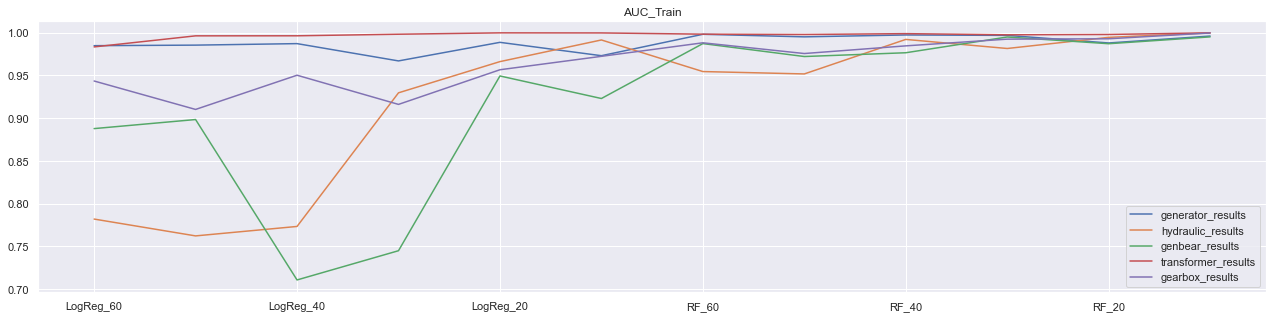

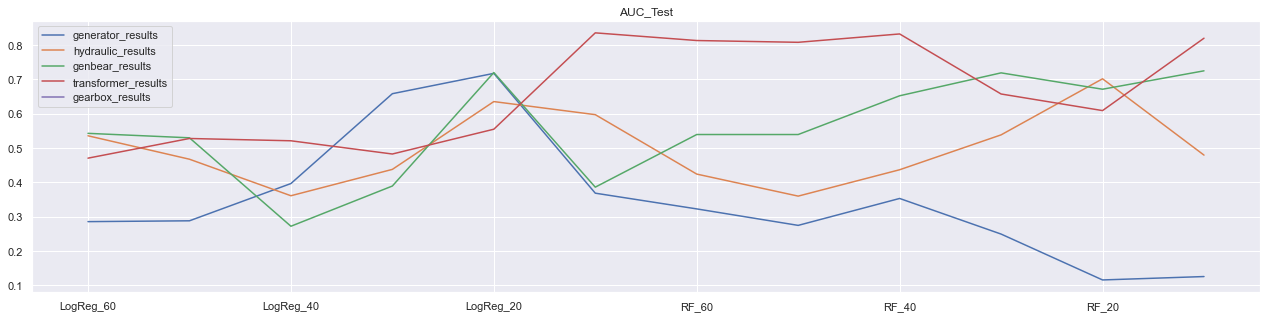

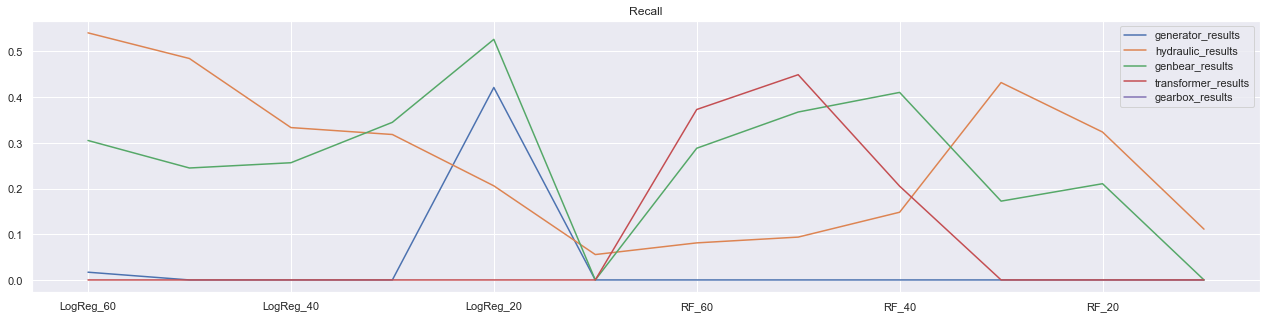

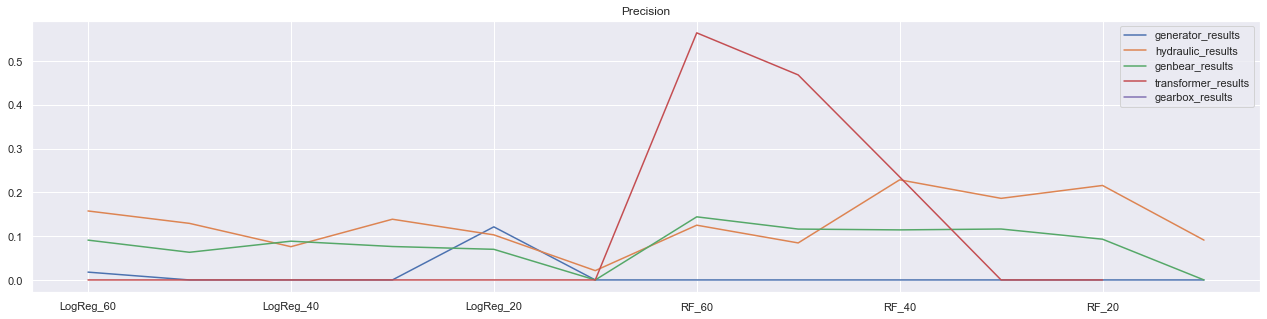

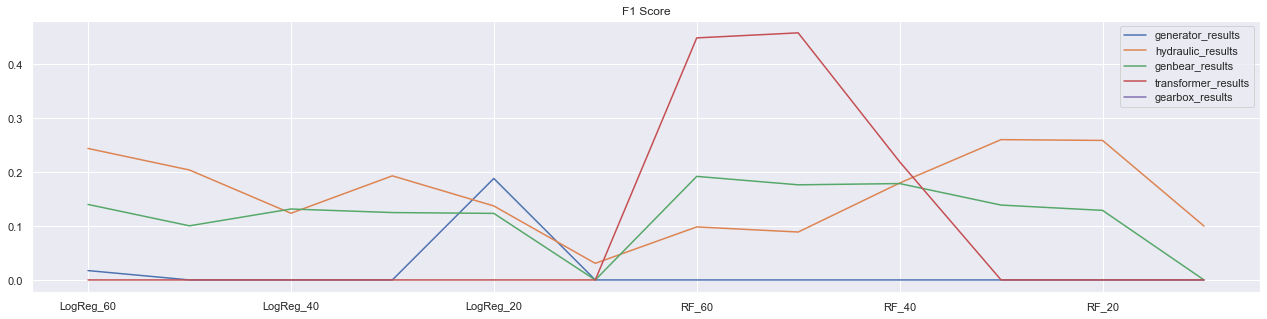

In [331]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(22,5))

for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['AUC_Train', :].plot(label=i)
plt.legend()
plt.title('AUC_Train')
#plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['AUC_Test', :].plot(label=i)
plt.legend()
plt.title('AUC_Test')
#plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Recall', :].plot(label=i)
plt.legend()
plt.title('Recall')
plt.show()


fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Precision', :].plot(label=i)
plt.legend()
plt.title('Precision')
plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['F1 Score', :].plot(label=i)
plt.legend()
plt.title('F1 Score')
plt.show()

In [264]:
dict_results_by_component['generator_results']

,LogReg_60,LogReg_50,LogReg_40,LogReg_30,LogReg_20,LogReg_10,RF_60,RF_50,RF_40,RF_30,RF_20,RF_10,KNN_60,KNN_50,KNN_40,KNN_30,KNN_20,KNN_10
AUC_Train,0.984710,0.985349,0.987111,0.966888,0.988606,0.972988,0.998021,0.995034,0.997234,0.996739,0.987874,0.995963,0.914772,0.923230,0.933719,0.942403,0.957342,0.972074
AUC_Test,0.285255,0.287677,0.396232,0.658020,0.717253,0.368177,0.322347,0.274333,0.352775,0.249011,0.115353,0.125244,0.523044,0.555288,0.609366,0.600443,0.518586,0.583455
Accuracy,0.756989,0.789247,0.808602,0.890323,0.851613,0.956989,0.761290,0.692473,0.750538,0.731183,0.632258,0.834409,0.866667,0.888172,0.911828,0.937634,0.959140,0.980645
Recall,0.016949,0.000000,0.000000,0.000000,0.421053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Specificity,0.864532,0.882212,0.882629,0.949541,0.869955,0.975877,0.871921,0.774038,0.819249,0.779817,0.659193,0.850877,0.992611,0.992788,0.995305,1.000000,1.000000,1.000000
Precision,0.017857,0.000000,0.000000,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
F1 Score,0.017391,0.000000,0.000000,0.000000,0.188235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [469]:
dict_results_by_component.keys()

dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])

In [470]:
dict_mod.keys()

dict_keys(['LogReg_60', 'LogReg_30'])

In [52]:
    #conf_matrix ( y_test, y_test_pred):
conf_matrix ( dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_true'], dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred']['y_test_pred'].values)


Predicted Class,0,1
Actual Class,,
0,255,210


 
generator_results LogReg_60
 


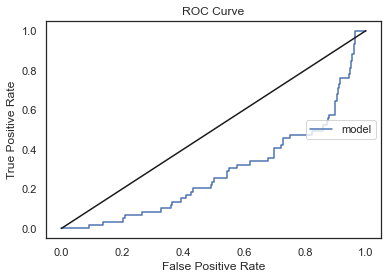

 
generator_results LogReg_50
 


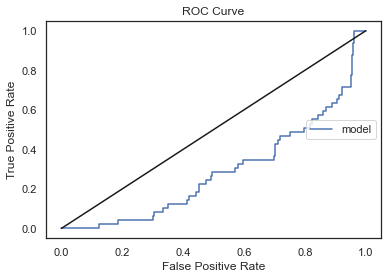

 
generator_results LogReg_40
 


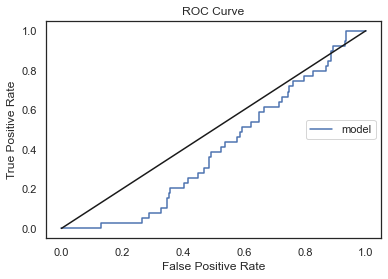

 
generator_results LogReg_30
 


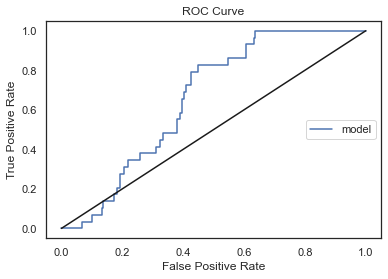

 
generator_results LogReg_20
 


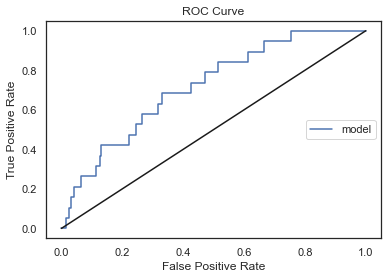

 
generator_results LogReg_10
 


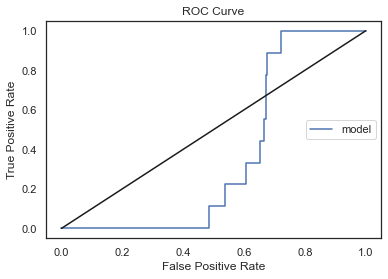

 
generator_results RF_60
 


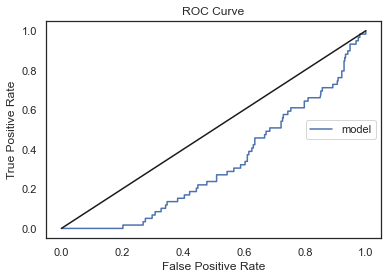

 
generator_results RF_50
 


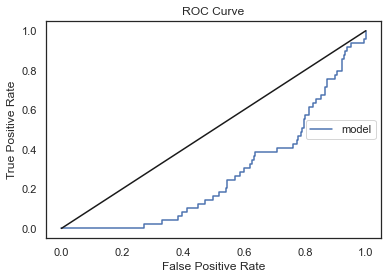

 
generator_results RF_40
 


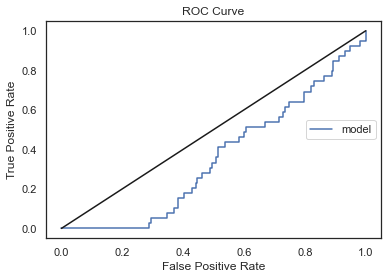

 
generator_results RF_30
 


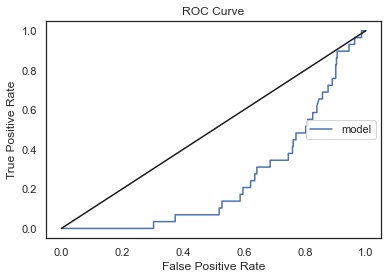

 
generator_results RF_20
 


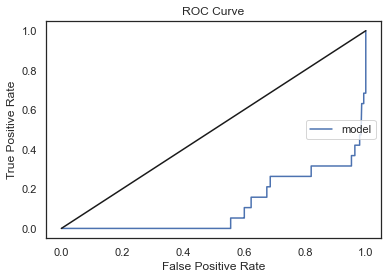

 
generator_results RF_10
 


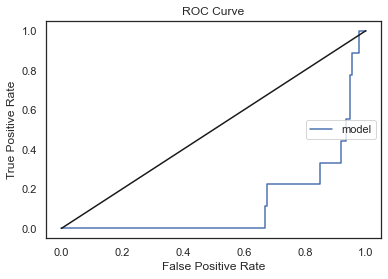

 
hydraulic_results LogReg_60
 


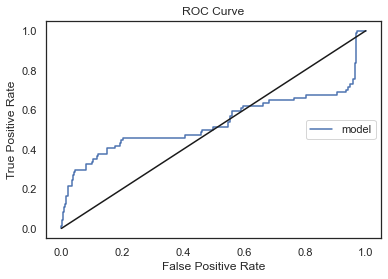

 
hydraulic_results LogReg_50
 


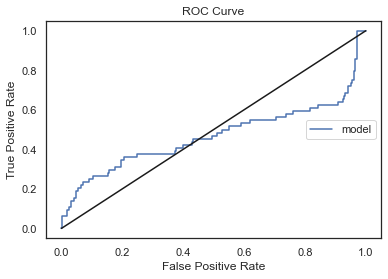

 
hydraulic_results LogReg_40
 


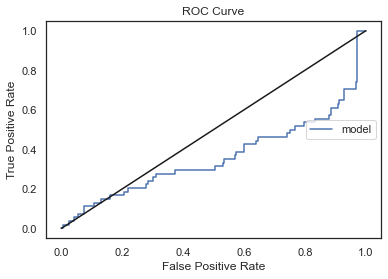

 
hydraulic_results LogReg_30
 


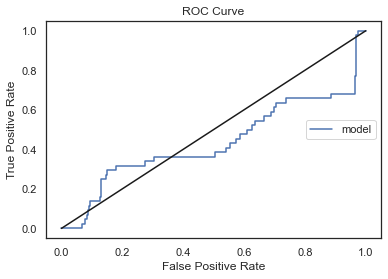

 
hydraulic_results LogReg_20
 


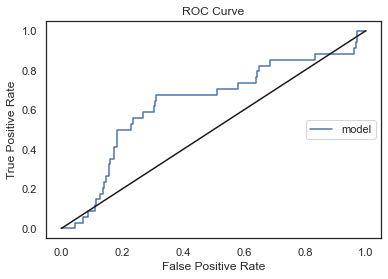

 
hydraulic_results LogReg_10
 


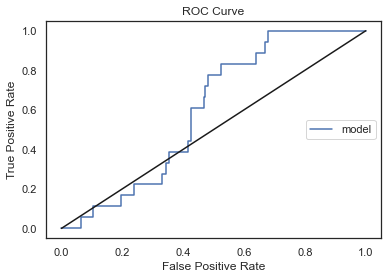

 
hydraulic_results RF_60
 


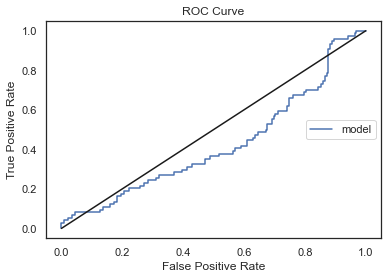

 
hydraulic_results RF_50
 


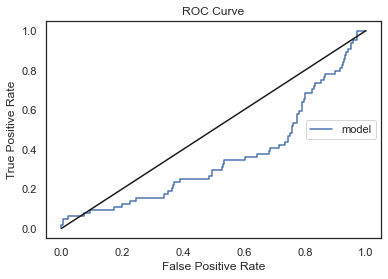

 
hydraulic_results RF_40
 


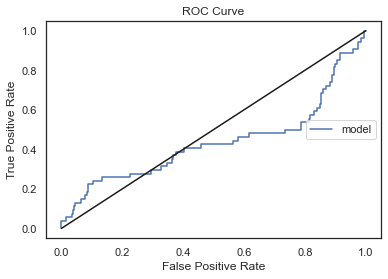

 
hydraulic_results RF_30
 


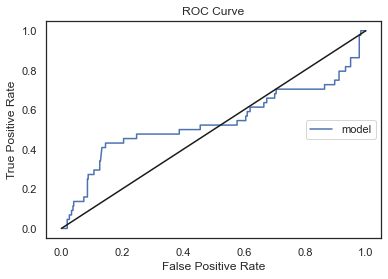

 
hydraulic_results RF_20
 


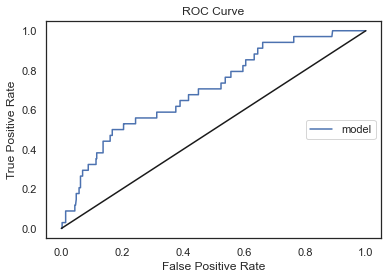

 
hydraulic_results RF_10
 


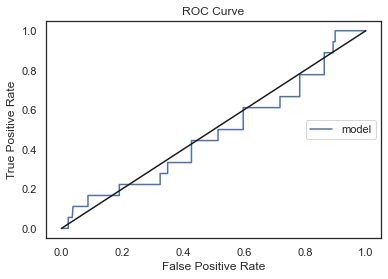

 
genbear_results LogReg_60
 


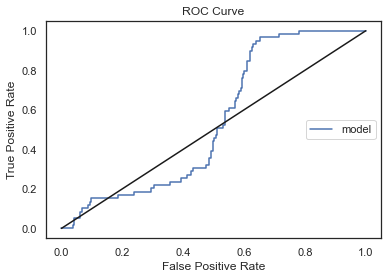

 
genbear_results LogReg_50
 


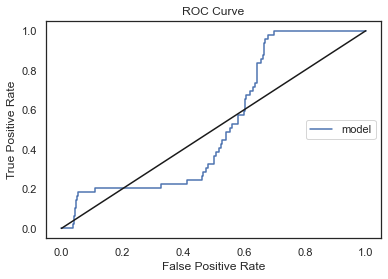

 
genbear_results LogReg_40
 


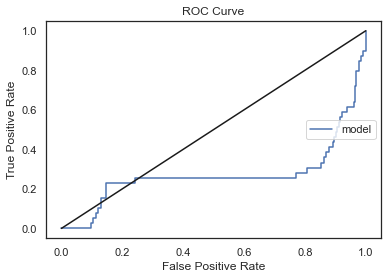

 
genbear_results LogReg_30
 


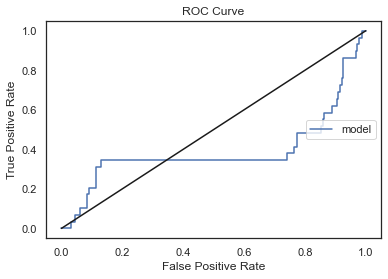

 
genbear_results LogReg_20
 


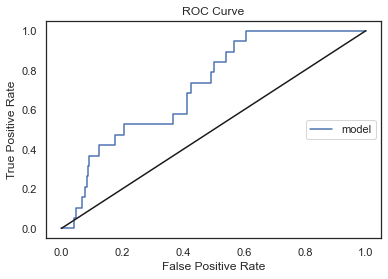

 
genbear_results LogReg_10
 


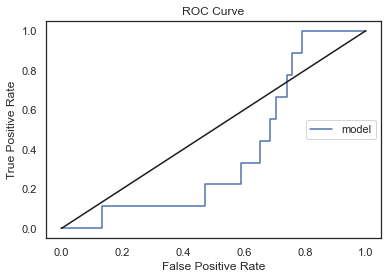

 
genbear_results RF_60
 


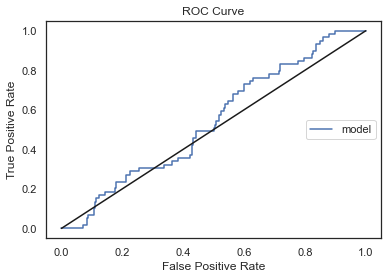

 
genbear_results RF_50
 


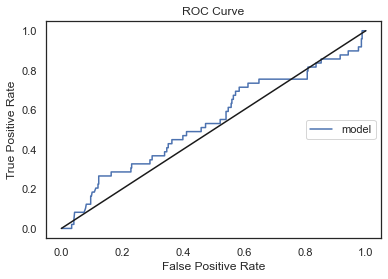

 
genbear_results RF_40
 


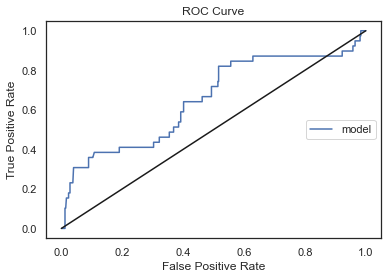

 
genbear_results RF_30
 


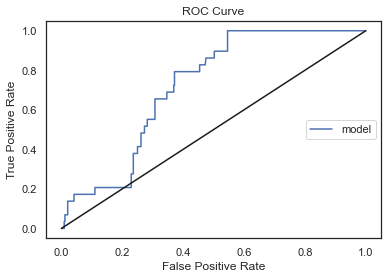

 
genbear_results RF_20
 


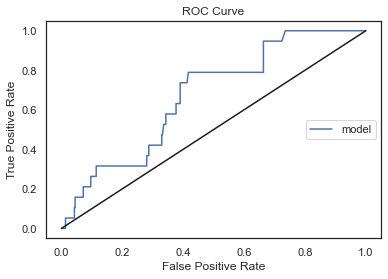

 
genbear_results RF_10
 


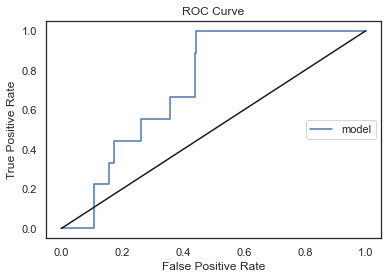

 
transformer_results LogReg_60
 


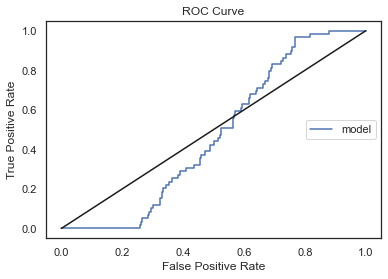

 
transformer_results LogReg_50
 


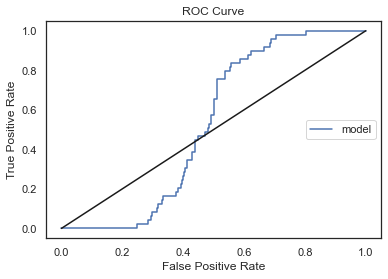

 
transformer_results LogReg_40
 


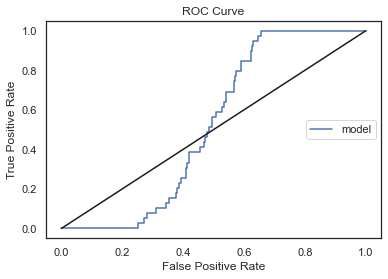

 
transformer_results LogReg_30
 


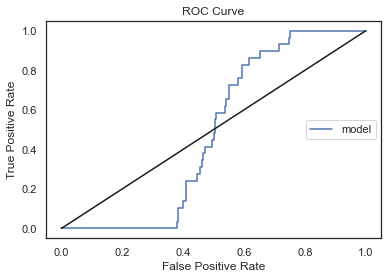

 
transformer_results LogReg_20
 


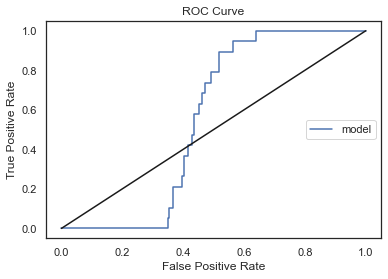

 
transformer_results LogReg_10
 


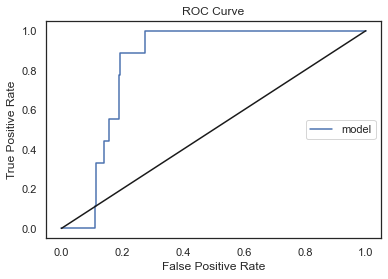

 
transformer_results RF_60
 


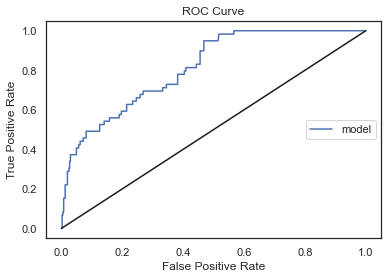

 
transformer_results RF_50
 


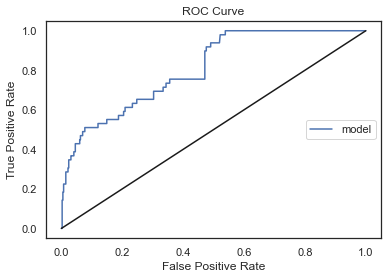

 
transformer_results RF_40
 


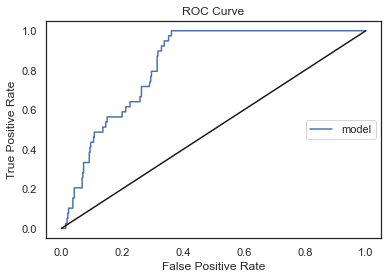

 
transformer_results RF_30
 


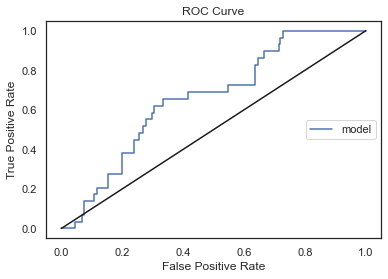

 
transformer_results RF_20
 


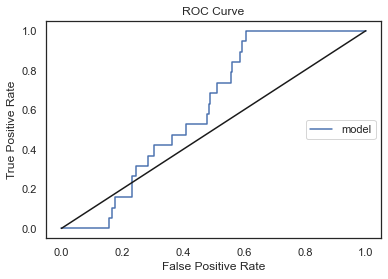

 
transformer_results RF_10
 


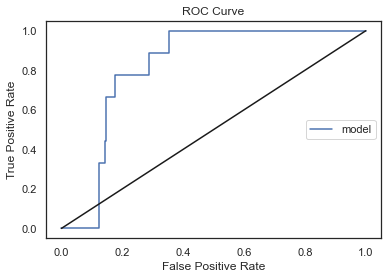

 
gearbox_results LogReg_60
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


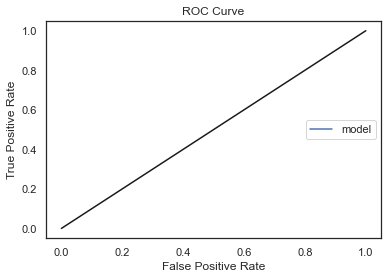

 
gearbox_results LogReg_50
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


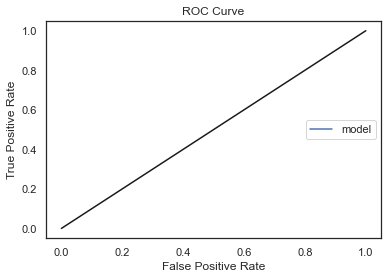

 
gearbox_results LogReg_40
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


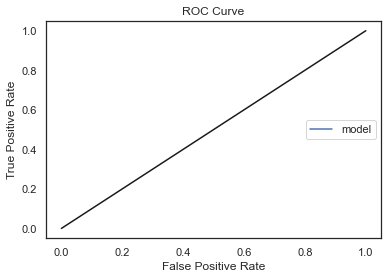

 
gearbox_results LogReg_30
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


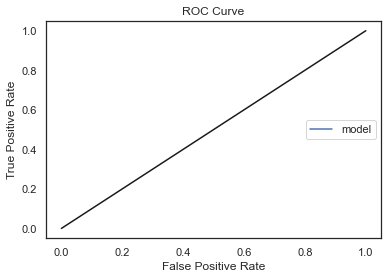

 
gearbox_results LogReg_20
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


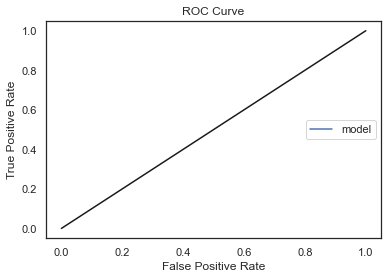

 
gearbox_results LogReg_10
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


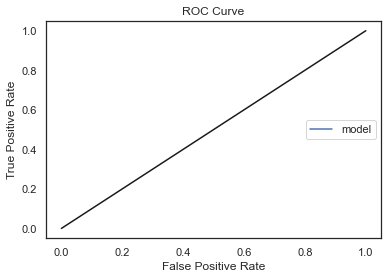

 
gearbox_results RF_60
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


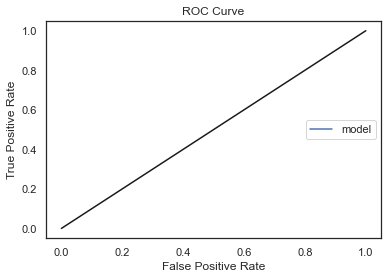

 
gearbox_results RF_50
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


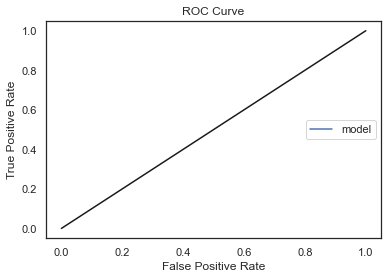

 
gearbox_results RF_40
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


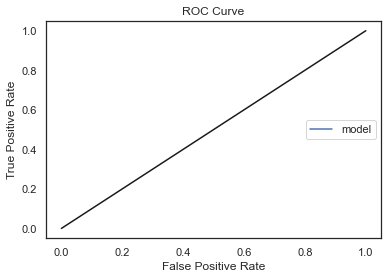

 
gearbox_results RF_30
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


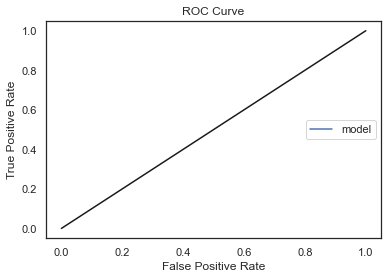

 
gearbox_results RF_20
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


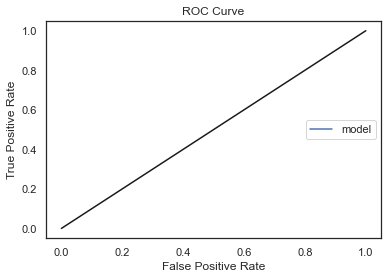

 
gearbox_results RF_10
 


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:786: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


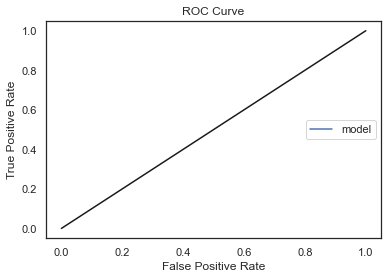

In [281]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        roc_curve_plot (dict_Y_pred_true_by_component[component][model]['test_true'],  dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob'].values)
        plt.show()

In [263]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        print(conf_matrix ( dict_Y_pred_true_by_component[component][model]['test_true'], dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_pred'].values))
        
    

 
generator_results LogReg_60
 
Predicted Class    0   1
Actual Class            
0                351  55
1                 58   1
 
generator_results LogReg_50
 
Predicted Class    0   1
Actual Class            
0                367  49
1                 49   0
 
generator_results LogReg_40
 
Predicted Class    0   1
Actual Class            
0                376  50
1                 39   0
 
generator_results LogReg_30
 
Predicted Class    0   1
Actual Class            
0                414  22
1                 29   0
 
generator_results LogReg_20
 
Predicted Class    0   1
Actual Class            
0                388  58
1                 11   8
 
generator_results LogReg_10
 
Predicted Class    0   1
Actual Class            
0                445  11
1                  9   0
 
generator_results RF_60
 
Predicted Class    0   1
Actual Class            
0                354  52
1                 59   0
 
generator_results RF_50
 
Predicted Class    0   1
Actual Class            
0 

1                 48  1
 
transformer_results KNN_40
 
Predicted Class    0  1
Actual Class           
0                424  2
1                 39  0
 
transformer_results KNN_30
 
Predicted Class    0  1
Actual Class           
0                435  1
1                 29  0
 
transformer_results KNN_20
 
Predicted Class    0
Actual Class        
0                446
1                 19
 
transformer_results KNN_10
 
Predicted Class    0
Actual Class        
0                456
1                  9
 
gearbox_results LogReg_60
 
Predicted Class    0    1
Actual Class             
0                255  210
 
gearbox_results LogReg_50
 
Predicted Class    0    1
Actual Class             
0                295  170
 
gearbox_results LogReg_40
 
Predicted Class    0    1
Actual Class             
0                289  176
 
gearbox_results LogReg_30
 
Predicted Class    0    1
Actual Class             
0                285  180
 
gearbox_results LogReg_20
 
Predicted Class    0    1
Actu

In [321]:
df_boxplot=pd.DataFrame(dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_true'].values,
dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred']['y_test_prob']).reset_index().rename(columns={0:'y_test_true'})

In [325]:
df_boxplot['y_test_true'].value_counts()

0    406
1     59
Name: y_test_true, dtype: int64

 
generator_results LogReg_60
 


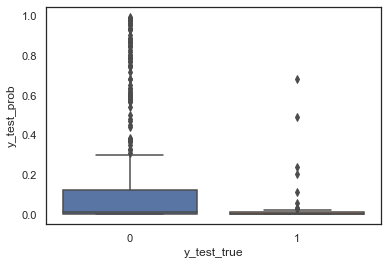

 
generator_results LogReg_50
 


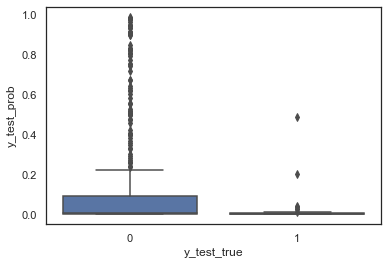

 
generator_results LogReg_40
 


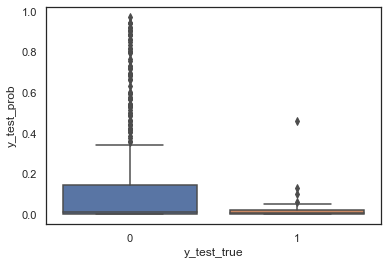

 
generator_results LogReg_30
 


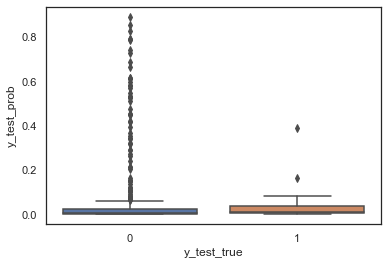

 
generator_results LogReg_20
 


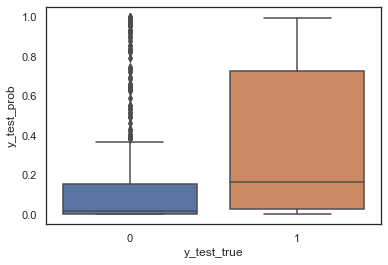

 
generator_results LogReg_10
 


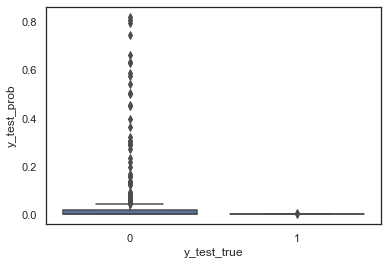

 
generator_results RF_60
 


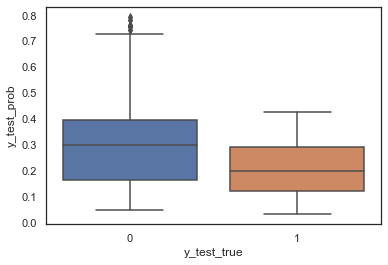

 
generator_results RF_50
 


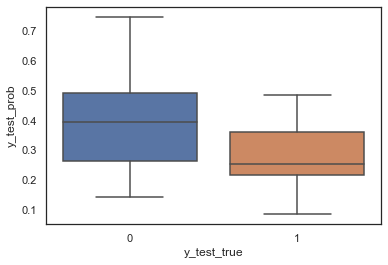

 
generator_results RF_40
 


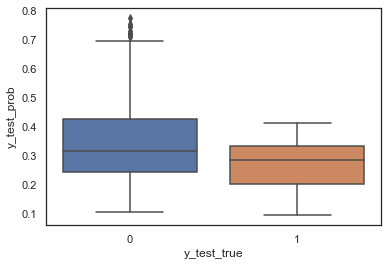

 
generator_results RF_30
 


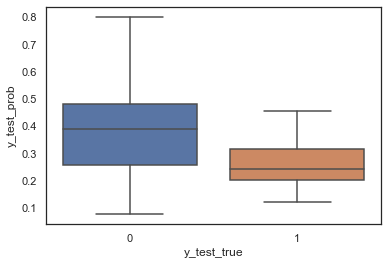

 
generator_results RF_20
 


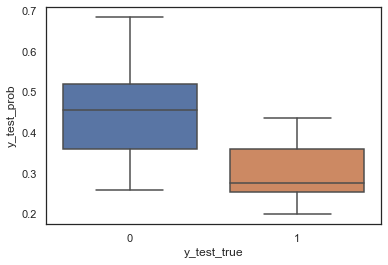

 
generator_results RF_10
 


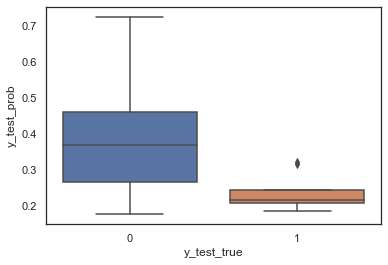

 
hydraulic_results LogReg_60
 


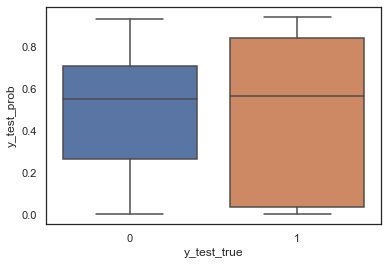

 
hydraulic_results LogReg_50
 


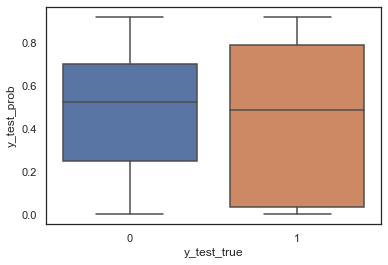

 
hydraulic_results LogReg_40
 


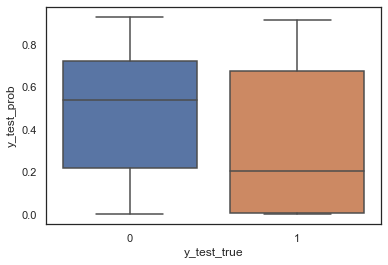

 
hydraulic_results LogReg_30
 


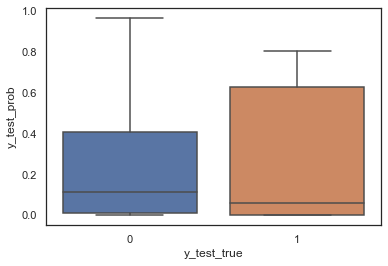

 
hydraulic_results LogReg_20
 


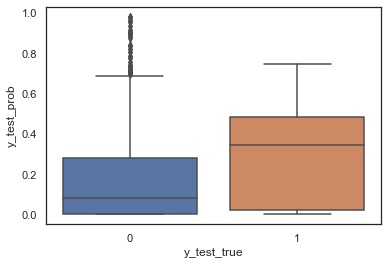

 
hydraulic_results LogReg_10
 


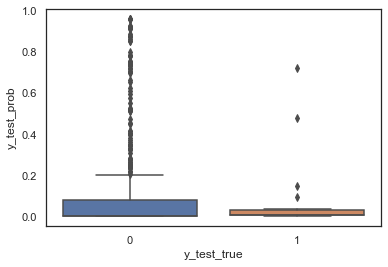

 
hydraulic_results RF_60
 


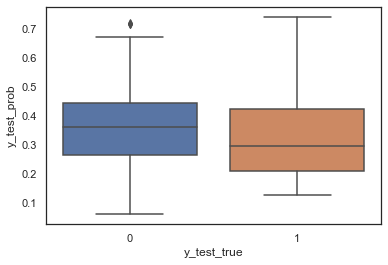

 
hydraulic_results RF_50
 


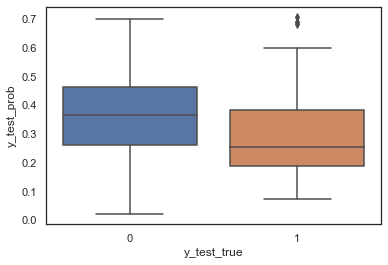

 
hydraulic_results RF_40
 


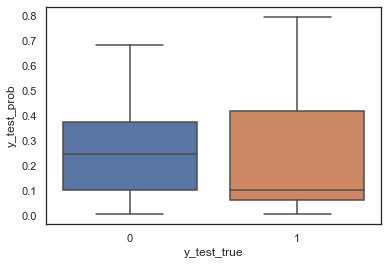

 
hydraulic_results RF_30
 


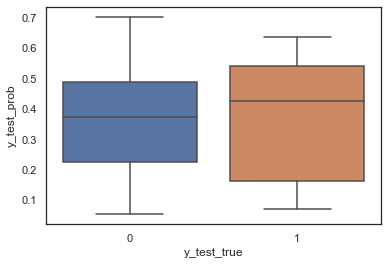

 
hydraulic_results RF_20
 


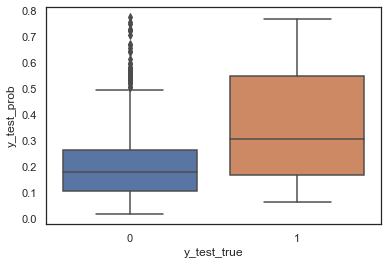

 
hydraulic_results RF_10
 


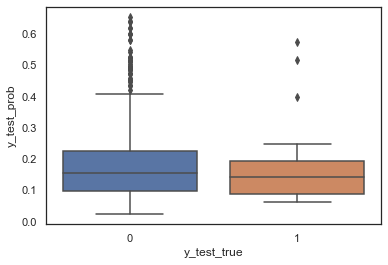

 
genbear_results LogReg_60
 


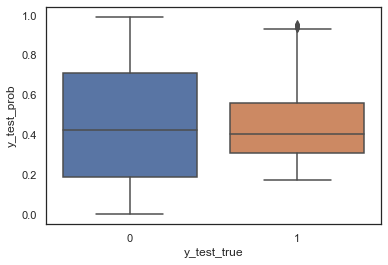

 
genbear_results LogReg_50
 


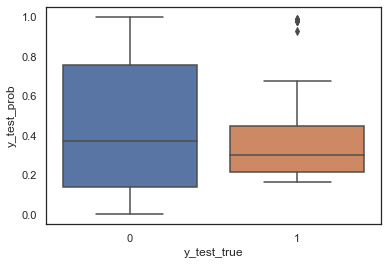

 
genbear_results LogReg_40
 


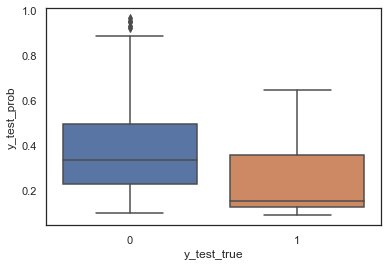

 
genbear_results LogReg_30
 


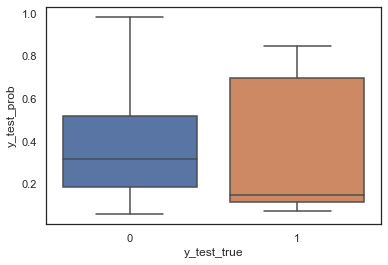

 
genbear_results LogReg_20
 


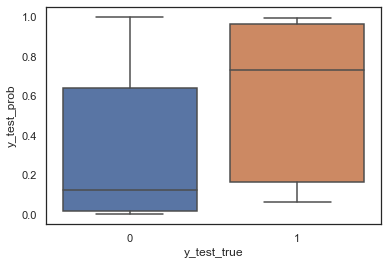

 
genbear_results LogReg_10
 


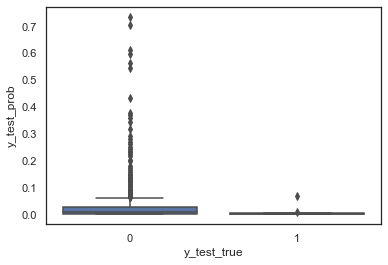

 
genbear_results RF_60
 


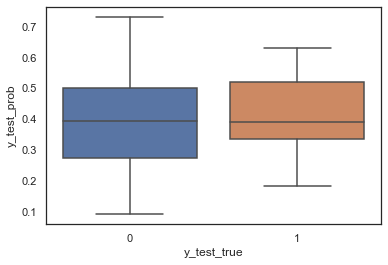

 
genbear_results RF_50
 


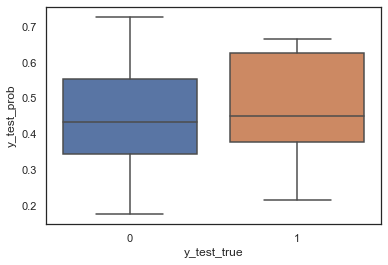

 
genbear_results RF_40
 


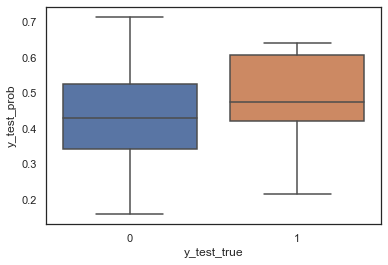

 
genbear_results RF_30
 


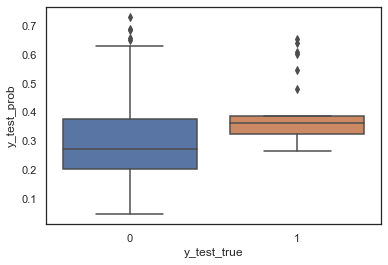

 
genbear_results RF_20
 


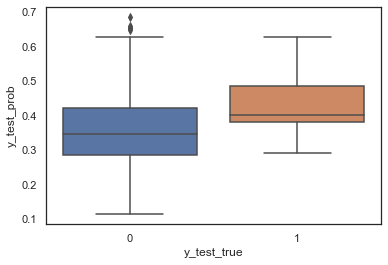

 
genbear_results RF_10
 


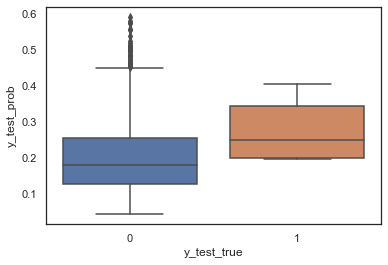

 
transformer_results LogReg_60
 


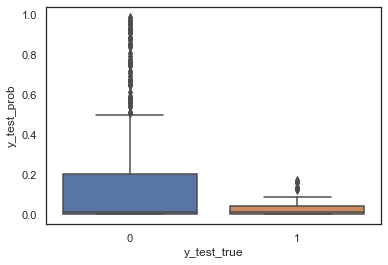

 
transformer_results LogReg_50
 


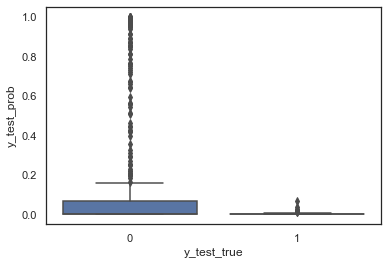

 
transformer_results LogReg_40
 


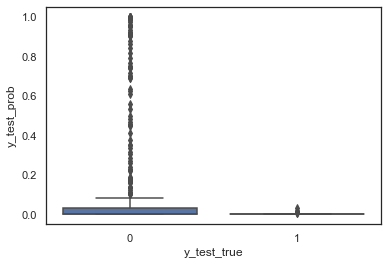

 
transformer_results LogReg_30
 


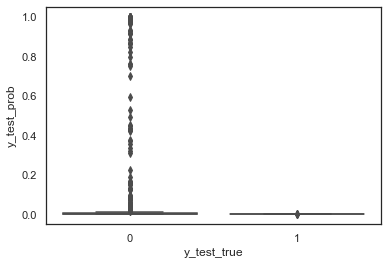

 
transformer_results LogReg_20
 


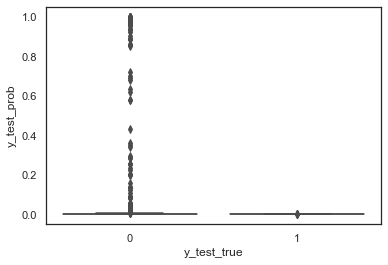

 
transformer_results LogReg_10
 


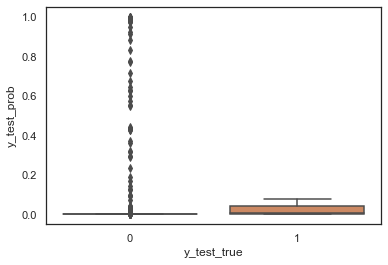

 
transformer_results RF_60
 


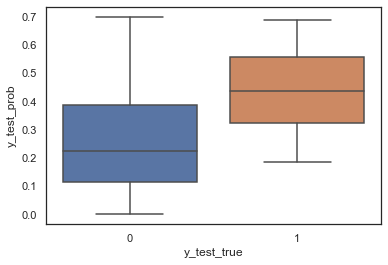

 
transformer_results RF_50
 


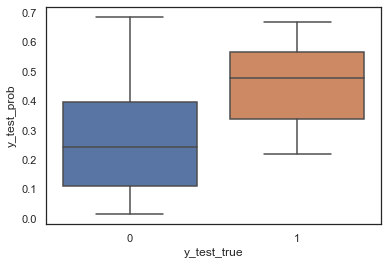

 
transformer_results RF_40
 


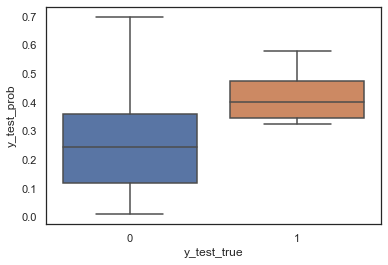

 
transformer_results RF_30
 


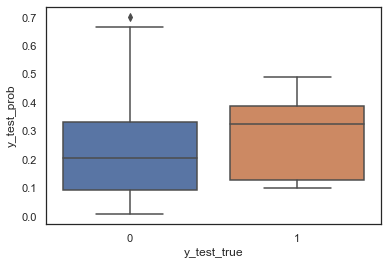

 
transformer_results RF_20
 


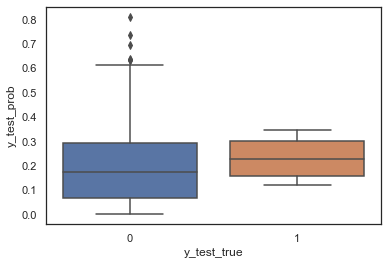

 
transformer_results RF_10
 


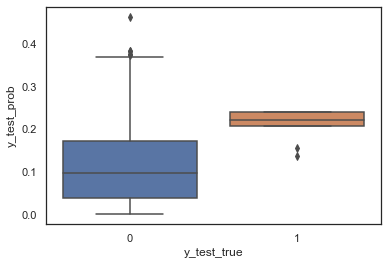

 
gearbox_results LogReg_60
 


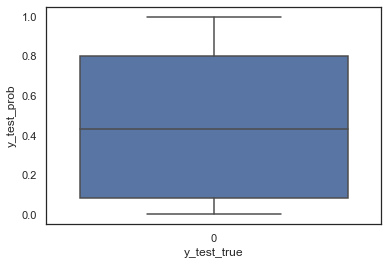

 
gearbox_results LogReg_50
 


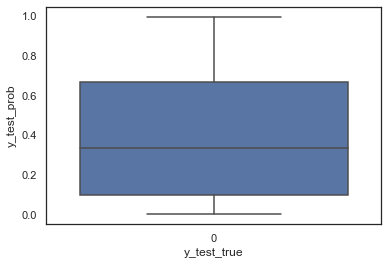

 
gearbox_results LogReg_40
 


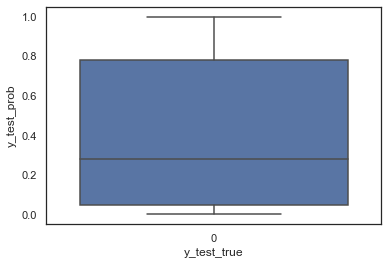

 
gearbox_results LogReg_30
 


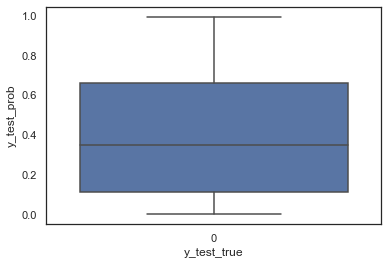

 
gearbox_results LogReg_20
 


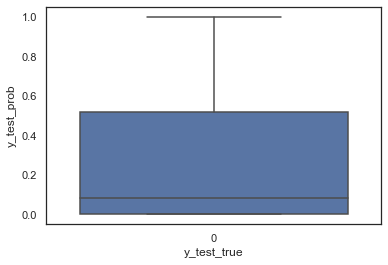

 
gearbox_results LogReg_10
 


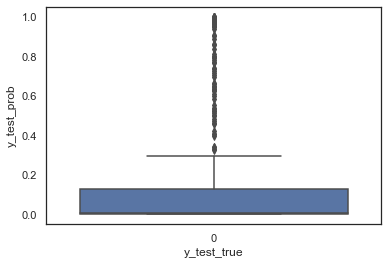

 
gearbox_results RF_60
 


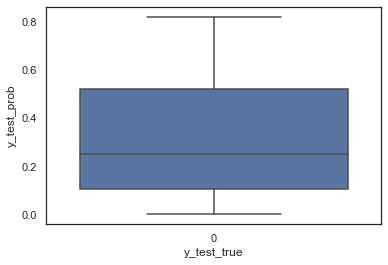

 
gearbox_results RF_50
 


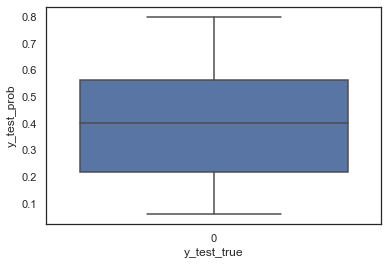

 
gearbox_results RF_40
 


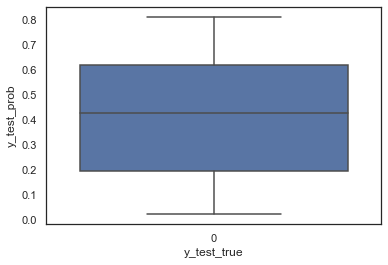

 
gearbox_results RF_30
 


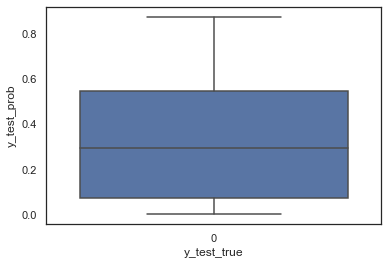

 
gearbox_results RF_20
 


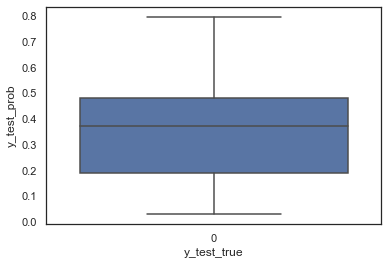

 
gearbox_results RF_10
 


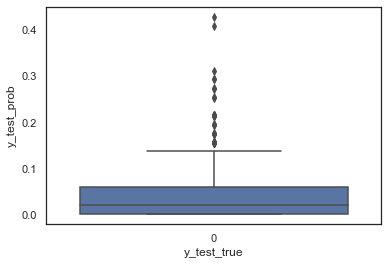

In [330]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        
        df_boxplot=pd.DataFrame(dict_Y_pred_true_by_component[component][model]['test_true'].values,
        dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob']).reset_index().rename(columns={0:'y_test_true'})
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        sns.boxplot(x="y_test_true", y="y_test_prob", data=df_boxplot)
        
        plt.show()

In [538]:
pd.DataFrame(dict_Y_pred_true_by_component['generator_results']['LogReg_60']['train_true']).value_counts()

60_days
0          2355
1           221
dtype: int64

In [53]:
pd.DataFrame(dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_true']).value_counts()

60_days
0          465
dtype: int64

In [485]:
#dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred']['y_test_pred'].unique()

In [540]:
pd.DataFrame(dict_Y_pred_true_by_component['generator_results']['LogReg_30']['test_true']).value_counts()

30_days
0          421
1           44
dtype: int64

In [243]:
df_test_generator['40_days'].value_counts()

0    426
1     39
Name: 40_days, dtype: int64

In [539]:
dict_df['generator_results'][1]['60_days'].value_counts()


0    406
1     59
Name: 60_days, dtype: int64

In [480]:
dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred']

,y_test_pred,y_test_prob
0,0,0.057211
1,0,0.256096
2,0,0.430105
3,0,0.107789
4,0,0.119878
...,...,...
460,1,0.989670
461,0,0.080684
462,1,0.947808
463,1,0.970133


In [259]:
dict_results_by_component.keys()

dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])

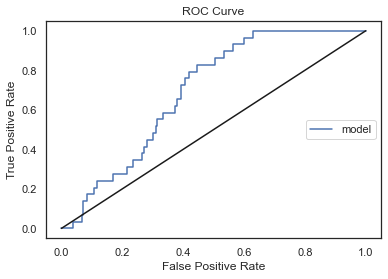

Predicted Class    0   1
Actual Class            
0                375  61
1                 22   7


{'AUC_Train': 0.9955067706196143,
 'AUC_Test': 0.6931350838342296,
 'Accuracy': 0.821505376344086,
 'Sensitivity': 0.2413793103448276,
 'Specificity': 0.8600917431192661,
 'Precision': 0.10294117647058823,
 'F1 Score': 0.14432989690721648,
 'Log Loss': 0.7378004671732987,
 'FBeta Score': 0.23820754716981135}

In [70]:

roc_curve_plot(df_test[target], pred_LogReg_test['y_test_prob'])
#roc_curve_plot(df_train[target], pred_LogReg_train['y_train_prob'])

conf_matrix (df_test[target].values,  pred_LogReg_test['y_test_pred'])

metrics (df_train[target], pred_LogReg_train['y_train_prob'], df_test[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob'])
     